In [1]:
import tensorflow as tf                         # Fundamental library for building and training neural networks
from tensorflow.keras.models import Sequential  # Creates a linear model where layers are stacked in order

# Layers include:
# - Input -> to define input dimensions (e.g., image size),  
# - Conv2D -> for extracting visual features,  
# - MaxPooling2D -> for dimensionality reduction while preserving key patterns,  
# - Flatten -> to transform multi-dimensional tensors into vectors,  
# - Dense -> for fully connected layers,  
# - Dropout -> to reduce overfitting,  
# - BatchNormalization -> to stabilize inner outputs (through normalization) and speed up training.
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import keras_tuner as kt                                            # Hyperparameter tuning library for Keras models
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard   # EarlyStopping (avoids overfitting by stoppping training if performance stops improving) and...
                                                                    # ... TensorBoard (visualize training and network structure)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np

My goal is to ensure the **reproducibility** of experiments.  

- With **TensorFlow**, fixing the seed controls operations such as weight initialization, batch selection and dropout application.  
- With **NumPy**, it applies to tasks like generating random arrays or shuffling data.  

Since Machine Learning and Deep Learning always involve some degree of randomness, running the same code without a fixed seed would yield slightly different results each time. By setting a seed, I guarantee that outcomes are **consistent and repeatable**, making it easier to compare experiments and allowing others to reproduce my results reliably.


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

x_train = df_train.drop("label", axis=1).values
y_train = df_train["label"].values

x_test = df_test.drop("label", axis=1).values
y_test = df_test["label"].values

For a preliminary analysis of this dataset, please refer to the **SVM notebook**.

Before feeding images into a convolutional neural network, their format must be adjusted.

Here, both training and test images are reshaped with "reshape(-1, 28, 28, 1)". This keeps the number of samples unchanged ("-1"), organizes each image as a 28×28 pixel grid and adds the channel dimension ("1" since images are grayscale). The result is a 4D tensor with the structure required by TensorFlow: (**samples, height, width, channels**).  

Next, the data is converted to "float32" for efficiency and normalized by dividing pixel values by 255. This scales them from the original range "[0, 255]" to "[0, 1]". Normalization is crucial, as it stabilizes computations and helps the network train more effectively.

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


The following function constructs a **convolutional neural network (CNN)** with tunable hyperparameters (via Keras Tuner),  such as selection of filter numbers, dropout rates, dense units and learning rates.

The model is sequential, designed for grayscale 28x28 images "(28,28,1)". It includes:

- **First convolutional block**: "Conv2D" with a number of convolutional filters (3x3 kernel, ReLu) ranging from 32 to 64 (hyperparameter tuning will select the optimal number of these filters), followed by "MaxPooling2D" (2x2). Optional "BatchNormalization" and dropout (to choose among 0.2 and 0.5) for regularization.  
- **Second convolutional block**: similar to the first but with more filters (among 64–128), pooling, optional batch normalization and dropout.  

After convolutional blocks, "Flatten" converts 2D feature maps into a 1D vector, necessary for a fully connected (Dense) layer. A fully connected (Dense) layer follows, with 64 through 256 units and ReLU activation, optionally followed by dropout. The **output layer** has 10 neurons (equal to the number of classes) with "softmax" activation for multi-class probabilities.

After defining the model, The "optimization" block code tells the model **how to update its weights** (optimizer), **how to measure errors** (loss) and **how to evaluate performance** (metrics) during training. The optimizer chosen is **Adam**, with a tunable learning rate (to choose among 0.01, 0.001 and 0.0001). For the loss funcion I use the "sparse_categorical_crossentropy" loss function, used for **multi-class classification** where labels are integers (e.g., [0, 2, 1, 4]) instead of one-hot encoded. Basically, it measures how close the model’s predicted probability is to the correct class, aiming to **maximize the probability of the true class** while minimizing the others. Ideal for integer-labeled multi-class problems. Finally, the metric chosen is the "accuracy" since the number of classes is balanced.


**In short**: in the next  cell code I build a flexible CNN with two convolutional blocks, optional batch normalization, tunable dropout, a dense layer and customizable optimization parameters, all manageable through Keras Tuner.


**NEURAL NETWORK**

Each neuron first computes a **weighted sum of its inputs plus a bias**:

$$
z_j = \sum_i \big(w_{ij} x_i + b_j\big)
$$

- $x_i$ = input from the previous layer  
- $w_{ij}$ = weight connecting input ($i$) to neuron ($j$)
- $b_j$ = bias of neuron ($j$)  

Next, a **ReLU activation** is applied:

$$
y_j = \text{ReLU}\big(z_j\big) = \max\big(0, z_j\big)
$$

This gives the output of the neuron:

$$
y_j = \text{ReLU}\Big(\sum_i w_{ij} x_i + b_j\Big)
$$

---

In the final layer, instead of ReLU, we use **Softmax** to convert outputs into probabilities, thus between 0 and 1:

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

- $C$ = number of classes (10 in my case)  
- $\hat{y}_i \in [0,1]$ and $\sum_{i=1}^{C} \hat{y}_i = 1$

In [5]:
def build_cnn(hp):
    model = Sequential()
    model.add(Input(shape=(28,28,1)))
    
    # First convolutional block
    model.add(Conv2D(
        filters = hp.Int("filters_1", 32, 64, step=16),
        kernel_size = (3,3),
        activation = 'relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if hp.Boolean("batchnorm_1"):   # If true, add batch normalization layer to the model
        model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))
    
    # Second convolutional block
    model.add(Conv2D(
        filters = hp.Int("filters_2", 64, 128, step=32),
        kernel_size = (3,3),
        activation = 'relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if hp.Boolean("batchnorm_2"):
        model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))
    
    # Flatten
    model.add(Flatten())
    
    # Dense layer
    model.add(Dense(
        units = hp.Int("dense_units", 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float("dropout_dense", 0.2, 0.5, step=0.1)))
    
    # Output
    model.add(Dense(10, activation="softmax"))
    
    # Model optimization
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])),
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model


**PRELIMINARY PROCEDURE AND SUPPORT FOR NEURAL NETWORK TRAINING**

In the following block I configure three key elements for monitoring a neural network training: the **hyperparameter tuner**, **early stopping** and **TensorBoard**.

The tuner explores different hyperparameter settings using the "build_cnn" function I previously defined to construct candidate CNN models. Its goal is to maximize validation accuracy (objective = "val_accuracy"), testing up to 10 trials (max_trals = 10) and saving results in the "tuner_results" folder under the "fashion-mnist_cnn" project. This allows the model to automatically identify the most effective configuration of filters, layer sizes or learning rates.

Saving the project has several advantages that make experimentation more efficient and reproducible. For istance, if training is interrupted (e.g., PC shutdown), I would be able to resume from where it was interrupted without starting from the begining. Furthermore, the best model’s weights and configuration are also stored automatically, allowing you to reload and reuse it without re-running the entire tuning process, which is quite long.

Early stopping monitors the validation loss (monitor = "val_accuracy"). If no improvement is observed after 5 consecutive epochs (patience = 5), training stops. With "restore_best_weights=True", the model reloads its best parameters rather than keeping the potentially worse final ones. This improves efficiency and helps prevent overfitting.

Finally, TensorBoard is configured to save training details in "./logs", including weight histograms ("histogram_freq = 1"). This tool provides real-time visualizations of loss, accuracy, weight distributions and even the network graph.

**In short:**  
- The tuner finds the best architecture automatically.  
- Early stopping prevents unnecessary training and overfitting.  
- TensorBoard offers visual monitoring of training progress.

In [ ]:
# Tuner setup
tuner = kt.RandomSearch(
    build_cnn,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,   # Number of execution per trial
    directory = "tuner_results",
    project_name = "fashion-mnist_cnn"
)

# Early stopping and TensorBoard
early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

tensorboard_callback = TensorBoard(
    log_dir = './logs', # Directory in which to save the log files
    histogram_freq = 1, # How often to log histogram visualizations (1 = every epoch)
    write_graph= True,  # Visualize the graph
    write_images= True  # Write model weights to visualize as image
)

In [7]:
# Searching for the best hyperparameters
tuner.search(
    x_train, y_train,
    validation_split = 0.2, # Portion of training data used for inner testing (or validation)
    epochs = 20,
    batch_size = 64,    # Number of samples before updating model weights
    callbacks = [early_stop, tensorboard_callback],
    verbose = 1
)

tuner.results_summary(num_trials=3) # Show a summary of the top 3 combinations

Trial 10 Complete [00h 08m 55s]
val_accuracy: 0.8612499833106995

Best val_accuracy So Far: 0.918583333492279
Total elapsed time: 00h 56m 31s
Results summary
Results in tuner_results\fashion-mnist_cnn
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
filters_1: 64
batchnorm_1: False
dropout_1: 0.30000000000000004
filters_2: 128
batchnorm_2: True
dropout_2: 0.4
dense_units: 128
dropout_dense: 0.2
lr: 0.0001
Score: 0.918583333492279

Trial 03 summary
Hyperparameters:
filters_1: 32
batchnorm_1: True
dropout_1: 0.30000000000000004
filters_2: 64
batchnorm_2: False
dropout_2: 0.4
dense_units: 128
dropout_dense: 0.30000000000000004
lr: 0.001
Score: 0.9144166707992554

Trial 00 summary
Hyperparameters:
filters_1: 32
batchnorm_1: True
dropout_1: 0.2
filters_2: 96
batchnorm_2: True
dropout_2: 0.4
dense_units: 128
dropout_dense: 0.30000000000000004
lr: 0.001
Score: 0.9132500290870667


The best configuration was achieved on the **fifth attempt**. This model architecture begins with **64 convolutional filters**, followed by a **30% dropout**. A second convolutional layer with **128 filters** is then applied, this time with **40% dropout** and normalization. The network then transitions to fully connected layers with **128 units** and a **20% dropout rate**.

This model reached an **accuracy of 91.86%** with a learning rate on the order of $10^{-4}$.

In [8]:
# Training with the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best CNN hyperparameter found:")
print(best_hp.values)

best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs= 20,
    batch_size= 64,
    callbacks= [early_stop, tensorboard_callback],
    verbose= 1
)

Best CNN hyperparameter found:
{'filters_1': 64, 'batchnorm_1': False, 'dropout_1': 0.30000000000000004, 'filters_2': 128, 'batchnorm_2': True, 'dropout_2': 0.4, 'dense_units': 128, 'dropout_dense': 0.2, 'lr': 0.0001}
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.7101 - loss: 0.8064 - val_accuracy: 0.8022 - val_loss: 0.5297
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.8171 - loss: 0.4956 - val_accuracy: 0.8536 - val_loss: 0.4084
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8472 - loss: 0.4203 - val_accuracy: 0.8677 - val_loss: 0.3680
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8600 - loss: 0.3833 - val_accuracy: 0.8804 - val_loss: 0.3315
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8737 - loss: 0.3496 - val_accuracy: 0.8854 - val_loss: 0.3179
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8798 - loss: 0.3296 - val_accuracy: 0.8900 - val_loss: 0.3032
Ep

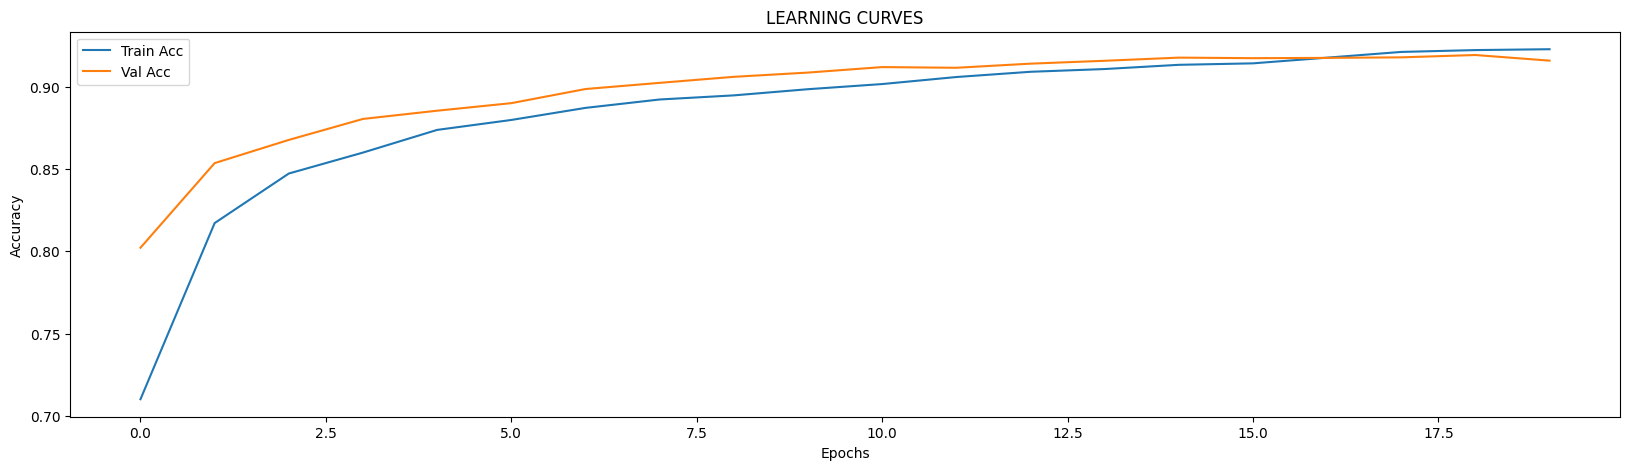

In [9]:
# 7. Learning curves
plt.figure(figsize=(20,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LEARNING CURVES")
plt.legend()


At the beginning of training, the **validation accuracy** was slightly higher than the **training accuracy**. This is a common behavior during the initial epochs because the network weights are not yet optimized for the training data, and early validation samples may appear easier or more representative.

As training progressed, the two curves intersected (around epochs 15–17): the **training accuracy** started rising more rapidly, signaling that the model was effectively learning internal data relationships. Both curves then stabilized at very high and nearly identical values (**92.28% for training** and **91.58% for validation**), a marginal gap of **0.70%**. This indicates excellent generalization with no evident overfitting.

Overall, the training dynamics describe a **healthy and balanced learning process**:  
- Smooth and consistent convergence  
- Minimal gap between training and validation performance  
- Strong generalization on unseen data  

In summary, the model demonstrates an **optimal fit**, effectively capturing meaningful patterns from the data while maintaining stability, low bias and low variance.

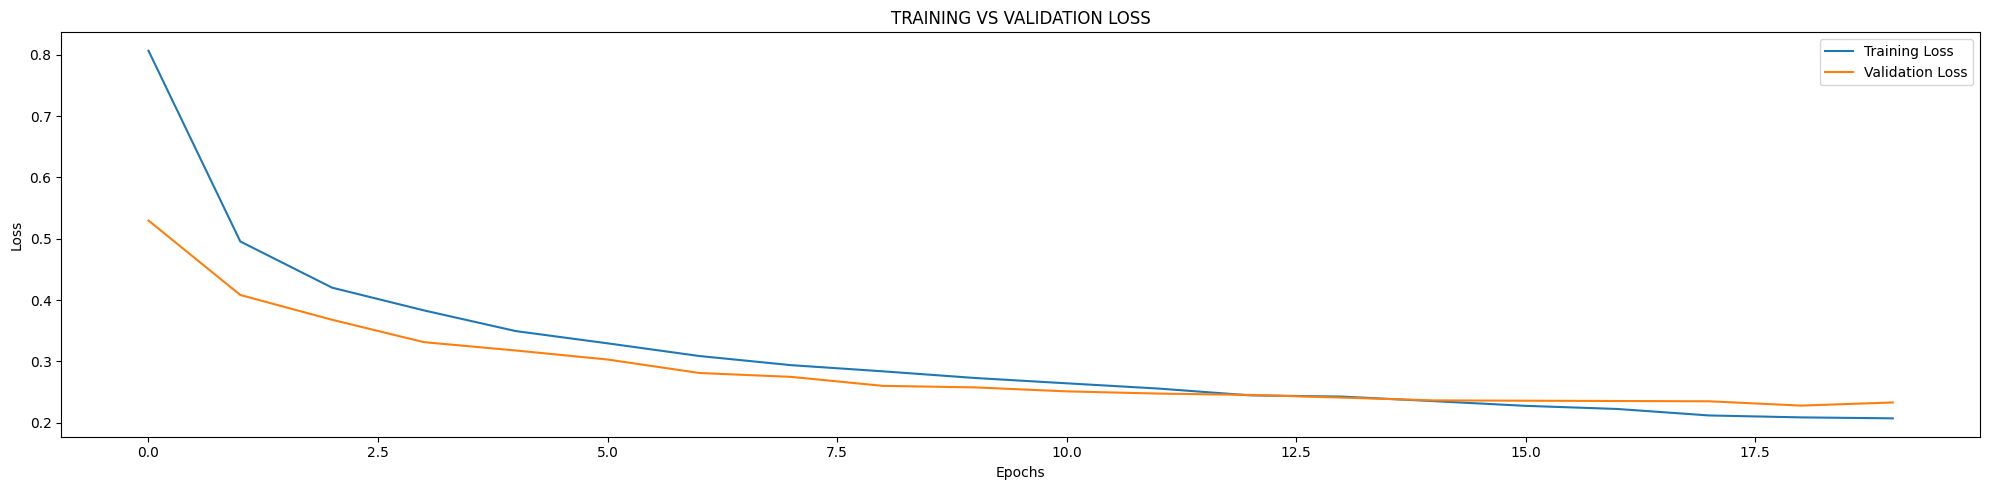

In [10]:
# Learning Curves: Loss
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TRAINING VS VALIDATION LOSS')
plt.legend()
plt.tight_layout()

The **loss curves** further support this observation. Initially, the validation loss was slightly lower, but both losses gradually decreased as the model improved. By the end of training, they stabilized at **0.21 (training)** and **0.23 (validation)**, showing a minimal and physiological difference. The absence of late-stage increases in validation loss confirms the model did not overfit.

This trend suggests two important points:  
- The similar downward trajectory of both curves indicates consistent learning, with no major gap between training and validation.  
- The final low loss (< 0.3) shows that residual errors are relatively small, meaning that the model achieves good predictive accuracy on both training and validation data.

In [11]:
# Predictions on test set
y_pred = np.argmax(best_model.predict(x_test), axis=1)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


array([0, 1, 2, ..., 8, 8, 1])

In [12]:
loss, acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"CNN accuracy on the test set: {100*acc:.2f}% with loss: {loss:.2f}")

CNN accuracy on the test set: 92.21% with loss: 0.22


The **test set achieved a good result**, with a loss of **0.22**. This suggests that the model not only learned effectively but may also generalize well to unseen data.

**CLASSIFICATION METRICS**

**1. Precision**
 
Precision measures the proportion of positive predictions that are actually correct.  

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Where:  
- **TP (True Positives)** = correct positive predictions  
- **FP (False Positives)** = incorrect positive predictions  

**In simple terms:** “If the model predicts positive, how often is it right?”  

---

**2. Recall (Sensitivity / Coverage)**

Recall measures the proportion of actual positives that the model successfully identifies.  

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Where:  
- **FN (False Negatives)** = positives missed by the model  

**In simple terms:** “Of all real positives, how many did the model catch?”

---

**Precision vs Recall:**
- **Precision** focuses on the quality of positive predictions (when the model says positive, is it correct?).  
- **Recall** focuses on completeness (how many of the actual positives did the model find?).  

---

**3. F1-score**  

to have a balance between precision and recall, I use the **F1-score**, the harmonic mean of the two:

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

A high F1-score indicates the model is good at **avoiding false positives** (precision) while also **catching most true positives** (recall).

In [13]:
# Converting the classification report to a DataFrame for better visualization
report = classification_report(y_true= y_test, y_pred= y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.873239,0.8680,0.870612,1000.0000
1,0.987026,0.9890,0.988012,1000.0000
2,0.897409,0.8660,0.881425,1000.0000
3,0.904762,0.9500,0.926829,1000.0000
4,0.882234,0.8690,0.875567,1000.0000
5,0.990854,0.9750,0.982863,1000.0000
6,0.780536,0.7860,0.783259,1000.0000
7,0.943160,0.9790,0.960746,1000.0000
8,0.987879,0.9780,0.982915,1000.0000
9,0.975635,0.9610,0.968262,1000.0000


In [14]:
# Selecting the relevant part of the report
df_report = df_report.iloc[:-3,:-1]
df_report

,precision,recall,f1-score
0,0.873239,0.868,0.870612
1,0.987026,0.989,0.988012
2,0.897409,0.866,0.881425
3,0.904762,0.950,0.926829
4,0.882234,0.869,0.875567
5,0.990854,0.975,0.982863
6,0.780536,0.786,0.783259
7,0.943160,0.979,0.960746
8,0.987879,0.978,0.982915
9,0.975635,0.961,0.968262


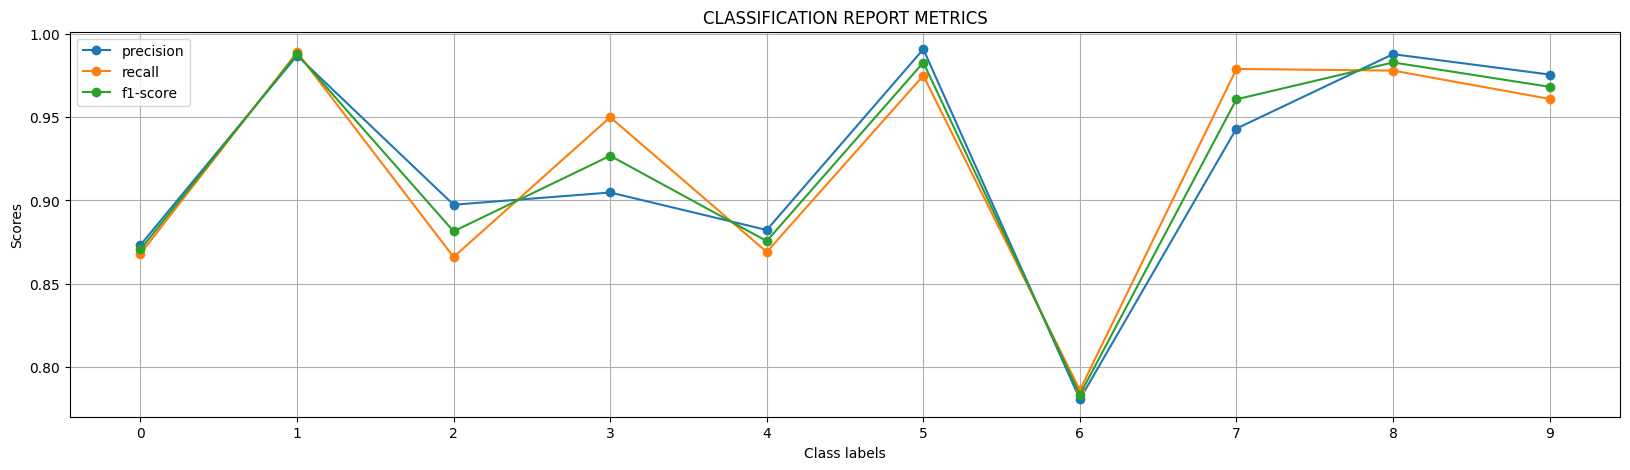

In [15]:
# Plotting
plt.figure(figsize=(20, 5))
for metric in df_report:
    plt.plot(df_report.index, df_report.loc[df_report.index, metric], label=metric, marker='o') # With \"index\" I access the row names

# Customization
plt.xlabel('Class labels')
plt.ylabel('Scores')
plt.title('CLASSIFICATION REPORT METRICS')
plt.legend()
plt.grid(True)
plt.show()

All evaluation metrics show consistent results. In particular, the model performs best on classes **1 (trousers), 5 (sandals) and 8 (bags)**, while class **6 (shirts)** proved to be the most challenging.

It is worth noting that the green curve (F1-score) generally lies between the other two curves, reflecting how it combines precision and recall into a single harmonic mean, as mentioned above.

**CONFUSION MATRIX**

A **confusion matrix** is used to evaluate the performance of a classification model in detail. It shows, for each class, how many examples were classified correctly and how many were misclassified.

**Rows represent real classes** and **columns represent predicted classes**. This layout makes it easy to identify which classes are often confused and to evaluate the model’s strengths and weaknesses in a clear and visual way.

Text(0.5, 1.0, 'CONFUSION MATRIX HEATMAP')

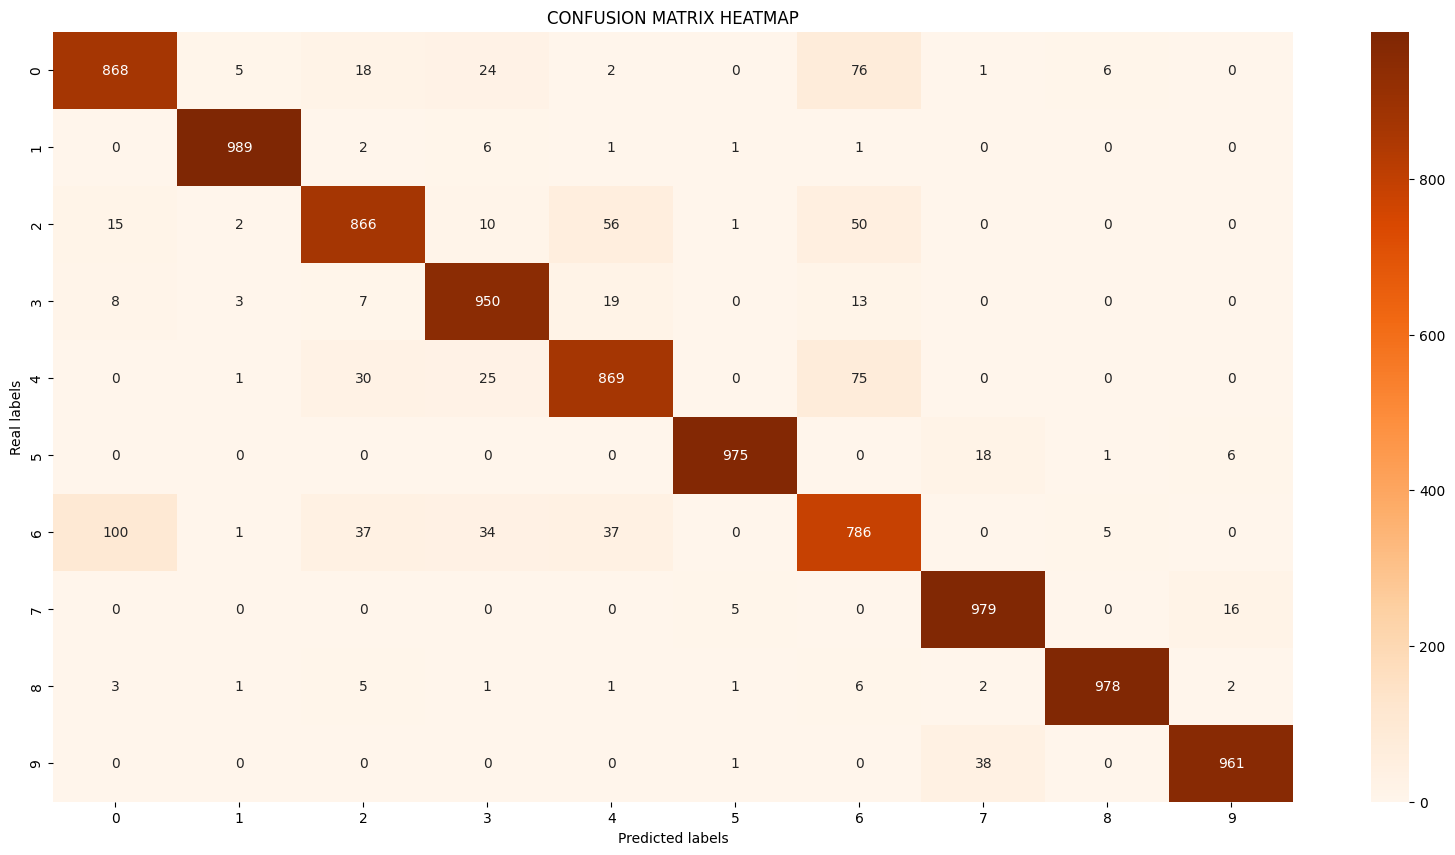

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true= y_test, y_pred= y_pred)

plt.figure(figsize=(20, 10))
sns.heatmap(cm,
            annot=True, # with "annot=True" the numbers will be shown inside each cell of the heatmap.
            fmt='d', cmap='Oranges', xticklabels=np.sort(np.unique(y_test)), yticklabels=np.sort(np.unique(y_test)))

plt.xlabel('Predicted labels')
plt.ylabel('Real labels')
plt.title('CONFUSION MATRIX HEATMAP')

The model struggles to accurately recognize **class 6 (shirt)**, frequently confusing it with **classes 0 (T-shirt/top), 2 (pullover) and 4 (coat)**. This suggests that the features distinguishing class 6 from these other classes may be subtle or overlapping, highlighting a potential area for feature refinement or additional data collection.

In [17]:
# Saving the model
best_model.save("best_mnist_cnn.keras")
print("CNN saved as 'best_mnist_cnn.keras'")


CNN saved as 'best_mnist_cnn.keras'


**CNN VS SVM**

In this study, a **Convolutional Neural Network (CNN)** was developed and compared with a **Support Vector Machine (SVM)** on the same multiclass classification task.  
Both models were trained and tested on identical data splits to ensure fair comparison and reproducibility.

Preprocessing

- **CNN**: required reshaping, conversion and scaling of input data, as convolutional layers operate on structured input tensors. These steps ensured compatibility with the network architecture and stable convergence.  
- **SVM**: involved feature scaling and optional **PCA** for dimensionality reduction, improving training stability and mitigating overfitting risks.

Evaluation Metrics

Both models were evaluated using identical metrics — **Accuracy, Precision, Recall, F1-score, Cross-Validation**, and **Confusion Matrix** to guarantee consistent assessment across approaches.

Results Summary

- **CNN**:  
  - Accuracy (train/test/validation): **≈92%**  
  - Average loss: **≈0.2**  
  - Demonstrated strong stability and generalization, supported by dropout and batch normalization.  

- **SVM**:  
  - Training accuracy: **97.2%**  
  - Test accuracy: **91.0%**  
  - Cross-validation: **≈90%**  
  - Good overall performance, though slightly more prone to overfitting.

Both models achieved solid results, with the **CNN slightly outperforming the SVM in prediction** (≈+0.5% in most metrics).

Confusion matrices revealed similar misclassification trends, suggesting that errors were due to inherent dataset complexity rather than model weakness.

#### Computational Aspects

Training and tuning times differed:  
- **CNN**: ≈60 minutes (including optimization).  
- **SVM**: ≈90 minutes (mainly due to hyperparameter exploration on "C", "kernel" and "gamma").  

While SVM tuning is computationally expensive, **CNNs leverage GPU acceleration**, making them faster to train despite higher architectural complexity.

Comparative Interpretation

| Aspect | **CNN** | **SVM** |
|:--|:--:|:--:|
| Test Accuracy | ~92% | 91.0% |
| Overfitting | none | minimal |
| Total training time | ~60 min | ~90 min |
| Interpretability | low | high |
| Architectural complexity | High | Low |
| Scalability | excellent | moderate |
| Generalization | very good | good |

Conclusions

The **CNN** demonstrated **superior generalization, stability and scalability**, excelling in adaptability to complex data and benefiting from GPU acceleration.  
Although the **SVM** remains simpler, more interpretable and effective for medium-sized datasets with structured features, the CNN ultimately provided **more balanced performance** across all datasets and metrics.

In summary, **the CNN prevailed in flexibility, speed and robustness**, whereas the **SVM** maintained advantages in simplicity and interpretability.